In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
import pyqsp
import multiprocessing
import itertools
import os, sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)
from QuSO_utils import *

In [3]:
# Environmental Parameters
T_env = 293       # Ambient temperature (K)
R_env = 0.01      # Convection resistance to ambient (K/W)

# Heat Flows (in Watts)
# Positive values indicate heat generation; negative values indicate cooling.
Q_1 = 2000    
Q_2 = 4000    
Q_3 = -200    
Q_4 = -2000   

# Inter-node Thermal Resistances (in K/W)
# These values lump together conduction and convection effects.
R_12 = 0.005
R_13 = 0.006
R_14 = 0.006
R_23 = 0.007
R_24 = 0.007
R_34 = 0.008

R_dict = {
    (0, 1): R_12,
    (0, 2): R_13,
    (0, 3): R_14,
    (1, 2): R_23,
    (1, 3): R_24,
    (2, 3): R_34
}

connections = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
conductance_coeffs = [1/R_12, 1/R_13, 1/R_14, 1/R_23, 1/R_24, 1/R_34, 1/(2*R_env), 0]
C_l = np.sum(conductance_coeffs)**(-1/2)
conductance_coeffs_amps = np.sqrt(conductance_coeffs)*C_l
B = np.array([Q_1, Q_2, Q_3, Q_4])
C_B = np.sum([el**2 for el in B])**(-1/2)
B_amps = C_B*B

In [4]:
# Create all possible configurations in natural order
bitstrings = list(itertools.product([0, 1], repeat=len(connections)))

# Calculate the corrsponding costs
costs = []
cond_list = []
for bitstring in bitstrings:
    A = build_A(bitstring, R_env, R_dict, connections)
    cond_list.append(np.linalg.cond(A))
    T = np.linalg.solve(A, B)
    costs.append(T[0]*2*C_B/(C_l**2))

kappa = np.max(cond_list)
_, C_p = pyqsp.poly.PolyOneOverX().generate(kappa, return_coef=True, ensure_bounded=True, return_scale=True, epsilon=0.05)
C_p = C_p[0]

costs = np.array(costs)*C_p

costs /= max(costs)

np.save("data/costs.npy", costs)

# Define cost Hamiltonian
H_C = qml.pauli_decompose(np.diag(costs))

b=343, j0=59
[PolyOneOverX] minimum [-11.82996188] is at [-0.0605411]: normalizing
[PolyOneOverX] bounding to 0.9


In [5]:
num_qaoa_wires = len(connections)

def U_C(gamma):
    qml.qaoa.cost_layer(gamma, H_C)

H_M = -1 * qml.PauliX(wires=0)
for wire in range(1, num_qaoa_wires):
    H_M -= qml.PauliX(wires=wire)
def U_M(beta):
    qml.qaoa.mixer_layer(beta, H_M)

1 Layer:
Initial cost: 0.45481448357001875, Minimum cost: 0.09920634920634915
Cost at step 44: 0.3236923960815881, diff: 1.0814010517057326e-062

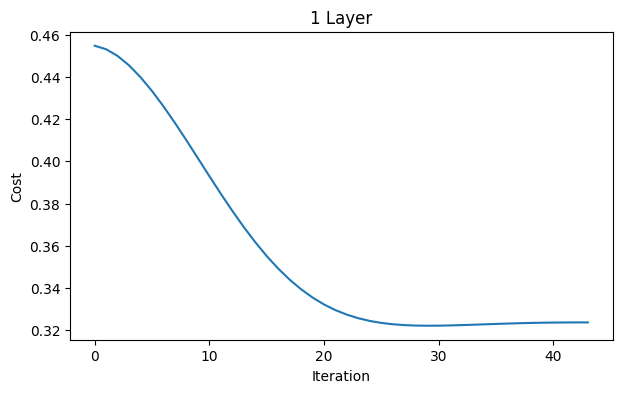

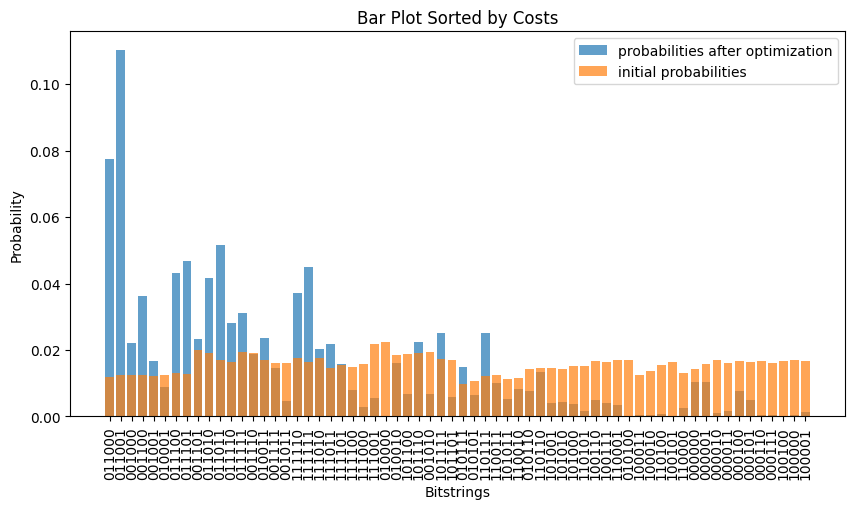

2 Layer:
Initial cost: 0.43995556169253597, Minimum cost: 0.09920634920634915
Cost at step 117: 0.23672918737923423, diff: 8.529543016111418e-065

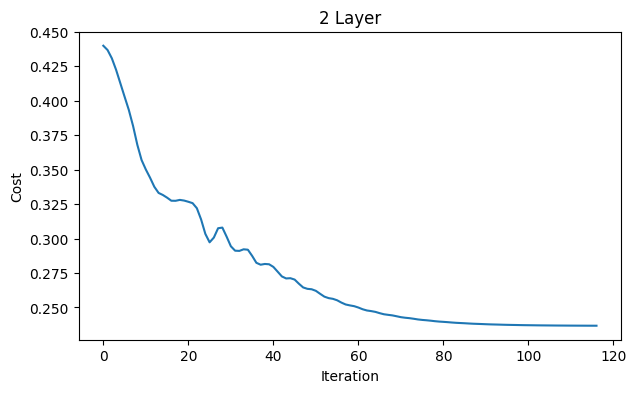

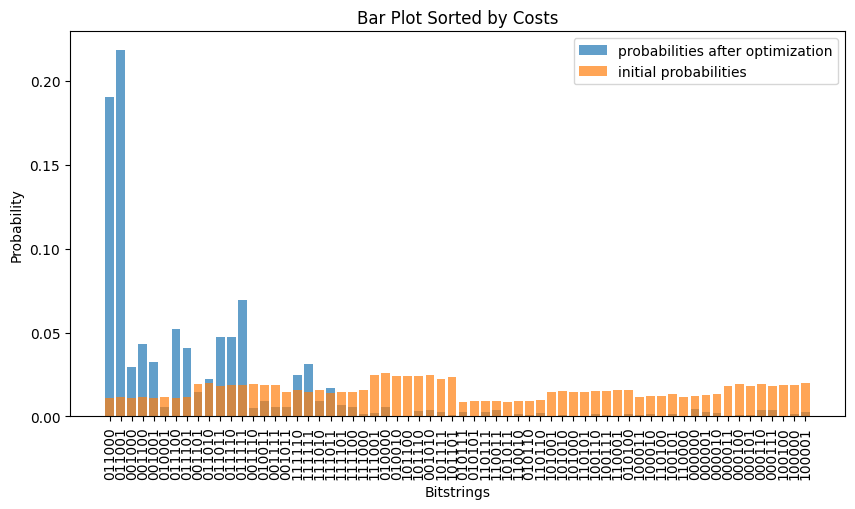

3 Layer:
Initial cost: 0.43963253068228103, Minimum cost: 0.09920634920634915
Cost at step 185: 0.18428452550935626, diff: 9.187124411086378e-065

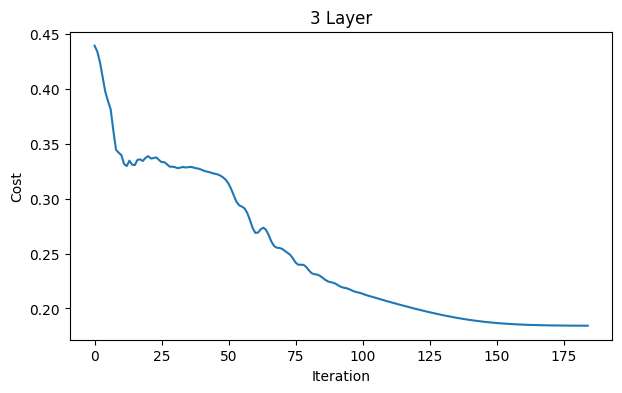

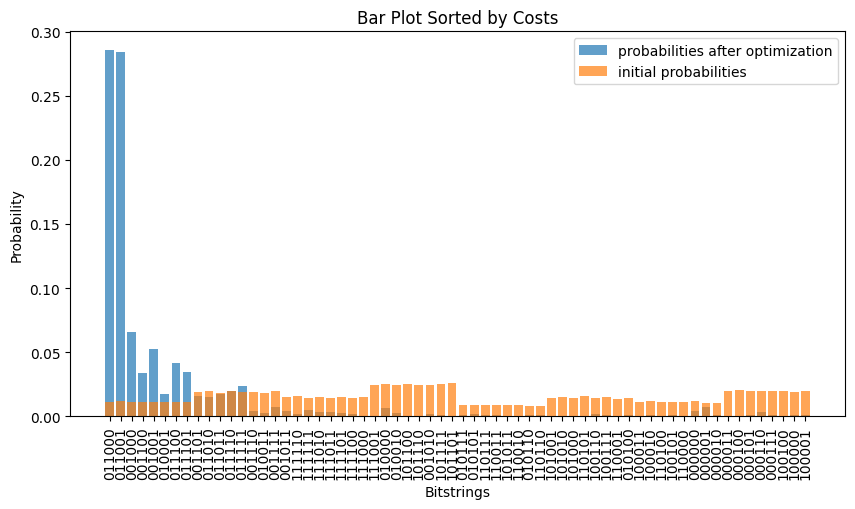

4 Layer:
Initial cost: 0.45057873912797247, Minimum cost: 0.09920634920634915
Cost at step 220: 0.1555713127738715, diff: 9.848901176834346e-0605

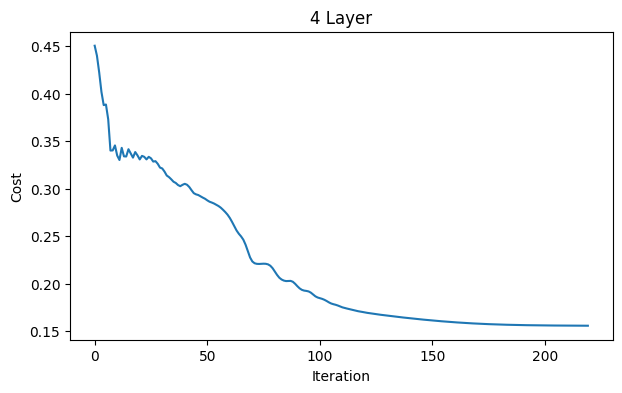

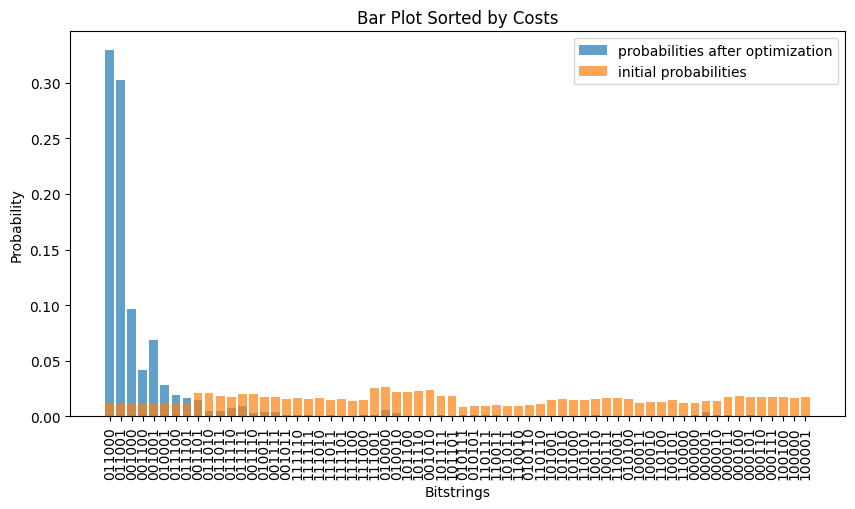

5 Layer:
Initial cost: 0.47708266125481313, Minimum cost: 0.09920634920634915
Cost at step 257: 0.1385316388641721, diff: 9.968892665190854e-0655

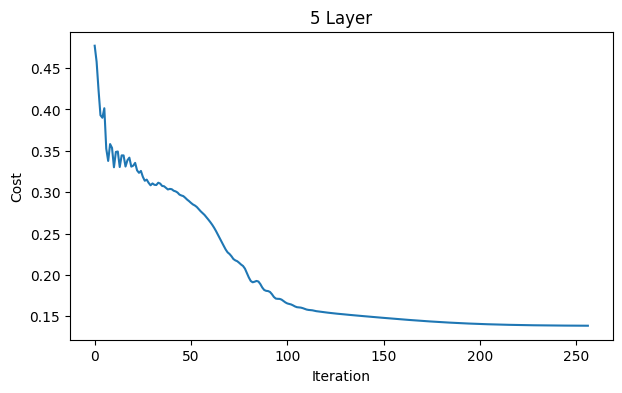

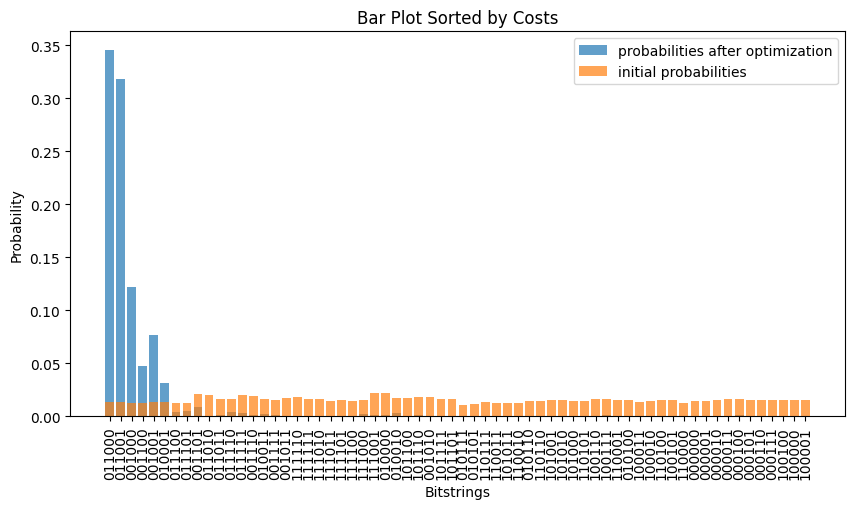

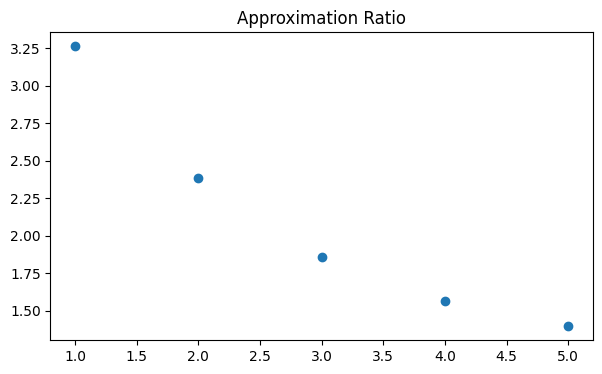

In [13]:
QAOA_results = {}
for depth in range(1, 6):
    print(f"{depth} Layer:")
    wires = range(num_qaoa_wires)

    # define a single qaoa layer
    def qaoa_layer(gamma, beta):
        U_C(gamma)
        U_M(beta)

    # define the qaoa circuit
    def qaoa_circuit(params):
        # Initialize ground state of mixer Hamiltonian
        for wire in wires:
            # qml.PauliX(wires=wire)
            qml.Hadamard(wires=wire)
        # Apply qaoa layers
        qml.layer(qaoa_layer, depth, params[0], params[1])

    # define cost function
    dev = qml.device("default.qubit", wires=wires)

    @qml.qnode(dev)
    def cost_function(params):
        qaoa_circuit(params)
        return qml.expval(H_C)
    
    optimizer = qml.MomentumOptimizer(stepsize=0.5)
    # optimizer = qml.qml.AdagradOptimizer(stepsize=1.0)
    # steps = 200
    gamma_start = 0.5
    beta_start = 0.5
    params = pnp.array([[gamma_start]*depth, [beta_start]*depth], requires_grad=True)
    params = pnp.array(params, requires_grad=True)
    cost_list = []
    params_list = []

    initial = True

    # start optimization
    #for step in range(steps):
    diff = 10
    step = 1
    while(diff > 1e-5):
        params, cost = optimizer.step_and_cost(cost_function, params)
        if step > 1:
            diff = abs(cost-cost_list[-1])
        cost_list.append(cost)
        params_list.append(params)
        if initial:
            print(f"Initial cost: {cost}, Minimum cost: {np.min(costs)}")
            initial = False
        print(f"Cost at step {step}: {cost}, diff: {diff}", end="\r")
        step += 1

    @qml.qnode(dev)
    def probability_circuit(gamma, beta):
        qaoa_circuit([gamma, beta])
        return qml.probs(wires=wires)

    probs = probability_circuit(params[0], params[1])
    probs_initial = probability_circuit(*params_list[0])

    QAOA_results[depth] = cost_list, [[list(np.array(el)) for el in tens] for tens in params_list], np.array(probs).tolist(), np.array(probs_initial).tolist(), cost/np.min(costs)

    plt.figure(figsize=(7, 4))
    plt.title(f"{depth} Layer")
    plt.plot(cost_list)
    plt.ylabel("Cost")
    plt.xlabel("Iteration")
    plt.show()

    bitstrings = [''.join(seq) for seq in itertools.product('01', repeat=num_qaoa_wires)]

    sorted_indices = sorted(range(len(costs)), key=lambda i: costs[i])
    sorted_probs = [probs[i] for i in sorted_indices]
    sorted_bitstrings = [bitstrings[i] for i in sorted_indices]

    plt.figure(figsize=(10, 5))
    plt.style.use('default')
    plt.bar(range(len(sorted_probs)), sorted_probs, label="probabilities after optimization", alpha=0.7)
    plt.bar(range(2 ** num_qaoa_wires), probs_initial, label="initial probabilities", alpha=0.7)
    plt.ylabel("Probability")
    plt.xlabel("Bitstrings")
    plt.xticks(ticks=range(len(sorted_bitstrings)), labels=sorted_bitstrings, rotation=90)
    plt.title("Bar Plot Sorted by Costs")
    # plt.xticks(ticks=range(2 ** num_qaoa_wires), labels=bitstrings, rotation=90)  # Add bitstrings as x labels
    plt.legend()
    plt.show()

plt.figure(figsize=(7, 4))
plt.title("Approximation Ratio")
plt.scatter([key for key in QAOA_results.keys()], [val[-1] for val in QAOA_results.values()])
plt.show()

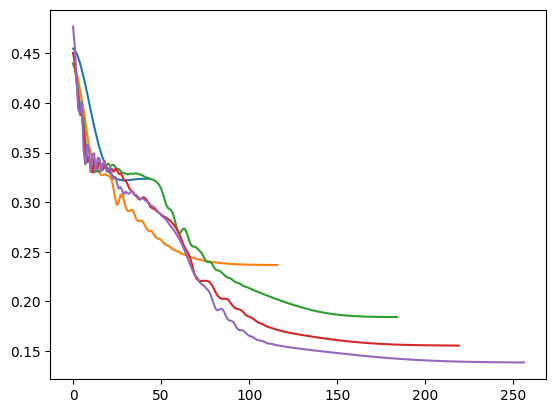

In [14]:
for depth in QAOA_results.keys():
    plt.plot(QAOA_results[depth][0])

In [15]:
import pickle 

with open('data/QAOA_data.pkl', 'wb') as f:
    pickle.dump(QAOA_results, f)

In [16]:
depth = 1

wires = range(num_qaoa_wires)

# define a single qaoa layer
def qaoa_layer(gamma, beta):
    U_C(gamma)
    U_M(beta)

# define the qaoa circuit
def qaoa_circuit(params):
    # Initialize ground state of mixer Hamiltonian
    for wire in wires:
        # qml.PauliX(wires=wire)
        qml.Hadamard(wires=wire)
    # Apply qaoa layers
    qml.layer(qaoa_layer, depth, params[0], params[1])

# define cost function
dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    qaoa_circuit(params)
    return qml.expval(H_C)

# Grid Definition
X = np.linspace(-np.pi/2, np.pi/2, 50)
Y = np.linspace(-3*np.pi, 3*np.pi, 50)
cost_surface = np.zeros((len(Y), len(X)))

# Helper function to evaluate cost in parallel
global evaluate_cost
def evaluate_cost(idx):
    i, j = idx
    return i, j, cost_function([[Y[i]], [X[j]]])

# Generate index pairs for parallel processing
index_pairs = [(i, j) for i in range(len(Y)) for j in range(len(X))]

# Run parallel computation
with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
    results = pool.map(evaluate_cost, index_pairs)

# Store results in cost_surface
for i, j, value in results:
    cost_surface[i, j] = value

X, Y = np.meshgrid(X, Y)

In [17]:
import pickle 

with open('data/QAOA_cost_landscape.pkl', 'wb') as f:
    pickle.dump([cost_surface, X, Y], f)